# Backfill Pipeline
* Fetch historical data from Open-Meteo
* Connect to the Hopsworks feature store
* Create feature groups and insert them to the feature store

In [1]:
import pandas as pd
import hopsworks
import openmeteo_requests
import requests_cache
from retry_requests import retry
import matplotlib.pyplot as plt
from weather_utils import *

import sys
sys.path.append('..')  # Add the parent directory (project root) to the Python path
from config import *

# Disable annoying warnings
import warnings
warnings.filterwarnings("ignore")

# Query Weather Data

In [2]:
# Create query parameters.
# Can query historical data up to 3 months
params = {
    "latitude": LATITUDE,
    "longitude": LONGITUDE,
    "daily": ["weather_code", "temperature_2m_min", "precipitation_sum", "wind_gusts_10m_max"],
    "timezone": TIMEZONE,
    "start_date": "2023-12-10",
    "end_date": "2024-01-18" # last day is not included
}

# Setup connection with Open-Meteo
openmeteo = get_openmeteo_connection()

# Execute the query
responses = openmeteo.weather_api(BASELINE_URL_OPEN_METEO, params=params)

# Extract the location because the response can be done for multiple cities as well
response = responses[0]

# Convert request to dataframe¶
df_hist_data = process_weather_request(response)

# Feature Engineering

In [3]:
# Process daily data into a Pandas dataframe
df_hist_data = process_weather_request(response)

### Remove missing values

In [4]:
# Check if there is any missing data
df_hist_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               40 non-null     object 
 1   weather_code_wmo   39 non-null     float32
 2   temperature_min    39 non-null     float32
 3   precipitation_sum  39 non-null     float32
 4   wind_gusts_max     39 non-null     float32
dtypes: float32(4), object(1)
memory usage: 1.1+ KB


In [5]:
# Remove missing days not accessible through the query
df_hist_data = df_hist_data.dropna()

# Convert the WMO weather codes column to integers
df_hist_data['weather_code_wmo'] = df_hist_data['weather_code_wmo'].astype(int)

# Check again if there is any missing data
df_hist_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 1 to 39
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               39 non-null     object 
 1   weather_code_wmo   39 non-null     int64  
 2   temperature_min    39 non-null     float32
 3   precipitation_sum  39 non-null     float32
 4   wind_gusts_max     39 non-null     float32
dtypes: float32(3), int64(1), object(1)
memory usage: 1.4+ KB


### Format values

In [6]:
# Add a new column with the month as an integer
df_hist_data['month'] = pd.to_datetime(df_hist_data['date']).dt.month

In [7]:
# Group WMO codes into labels and new group code label
df_hist_data = group_wmo_weather_codes(df_hist_data)

In [8]:
# Add weather code descriptions
df_hist_data = add_weather_code_labels(df_hist_data)

# Visualize

### Manual inspection

In [9]:
# Newest values
print('Newest values:')
display(df_hist_data.tail())

# Oldest values
print('Oldest values:')
display(df_hist_data.head())

Newest values:


,date,weather_code_wmo,temperature_min,precipitation_sum,wind_gusts_max,month,weather_code,weather_code_desc,weather_code_desc_short
34,2024-01-13,73,-2.1825,1.300000,33.119999,1,8,"Snow fall: Slight, moderate, and heavy intensity",Snow
35,2024-01-14,73,-7.9825,4.399999,47.160000,1,8,"Snow fall: Slight, moderate, and heavy intensity",Snow
36,2024-01-15,71,-12.8325,0.300000,39.599998,1,8,"Snow fall: Slight, moderate, and heavy intensity",Snow
37,2024-01-16,75,-11.4325,7.700000,77.039993,1,8,"Snow fall: Slight, moderate, and heavy intensity",Snow
38,2024-01-17,71,-7.5325,0.200000,49.320000,1,8,"Snow fall: Slight, moderate, and heavy intensity",Snow


Oldest values:


,date,weather_code_wmo,temperature_min,precipitation_sum,wind_gusts_max,month,weather_code,weather_code_desc,weather_code_desc_short
0,2023-12-10,77,-1.4955,4.699999,37.079998,12,9,Snow grains,Snow
1,2023-12-11,3,-3.9455,0.000000,28.799999,12,2,"Mainly clear, partly cloudy, and overcast",Clear
2,2023-12-12,3,-4.4955,0.000000,25.919998,12,2,"Mainly clear, partly cloudy, and overcast",Clear
3,2023-12-13,2,-7.7455,0.000000,25.919998,12,2,"Mainly clear, partly cloudy, and overcast",Clear
4,2023-12-14,3,-7.5955,0.000000,20.160000,12,2,"Mainly clear, partly cloudy, and overcast",Clear


### Plot trends

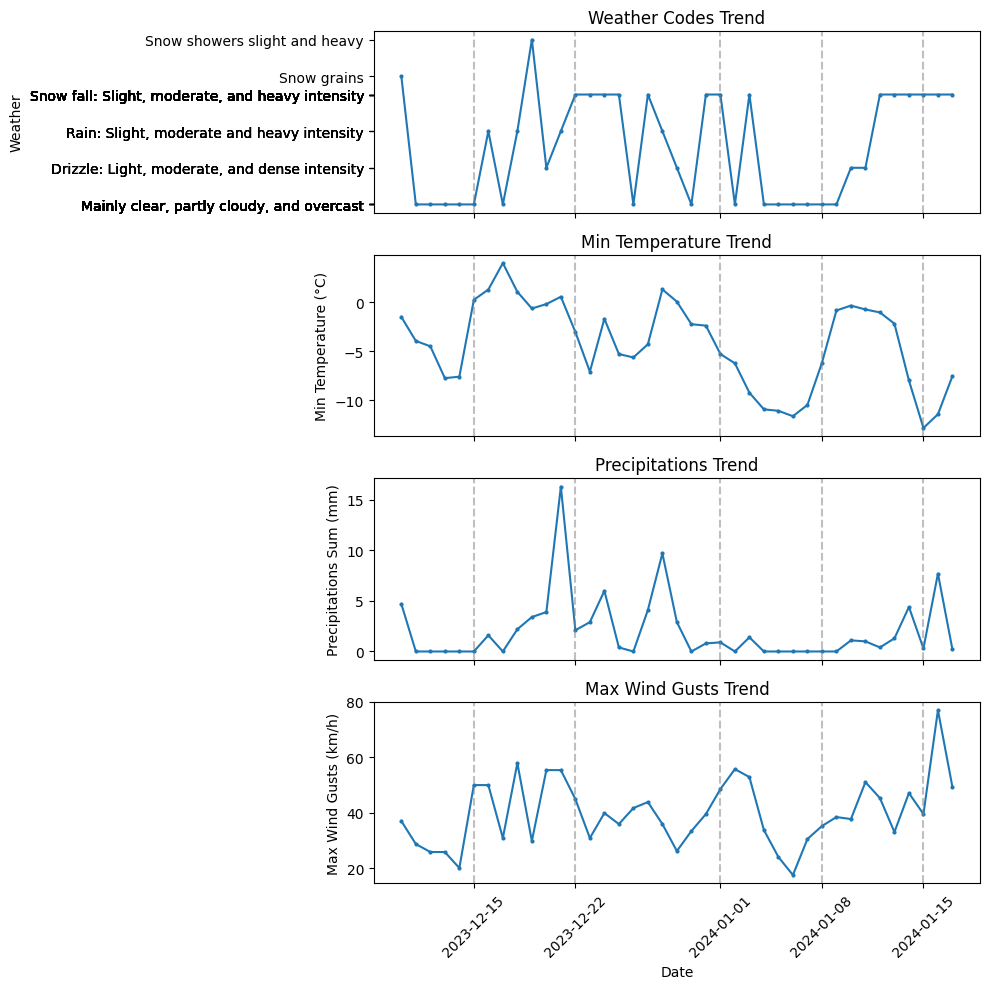

In [10]:
# Create a figure with four vertically aligned subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

# First subplot: Weather Code
ax1.plot(df_hist_data['date'], df_hist_data['weather_code'], marker='o', linestyle='-', markersize=2)
ax1.set_ylabel('Weather')
ax1.set_title('Weather Codes Trend')

# Customize y-axis labels with weather code labels instead of numbers
ax1.set_yticks(df_hist_data['weather_code'])
ax1.set_yticklabels(df_hist_data['weather_code_desc'])

# Second subplot: Min Temperature
ax2.plot(df_hist_data['date'], df_hist_data['temperature_min'], marker='o', linestyle='-', markersize=2)
ax2.set_ylabel('Min Temperature (°C)')
ax2.set_title('Min Temperature Trend')

# Third subplot: Precipitations Sum
ax3.plot(df_hist_data['date'], df_hist_data['precipitation_sum'], marker='o', linestyle='-', markersize=2)
ax3.set_ylabel('Precipitations Sum (mm)')
ax3.set_title('Precipitations Trend')

# Fourth subplot: Max Wind Gusts
ax4.plot(df_hist_data['date'], df_hist_data['wind_gusts_max'], marker='o', linestyle='-', markersize=2)
ax4.set_xlabel('Date')
ax4.set_ylabel('Max Wind Gusts (km/h)')
ax4.set_title('Max Wind Gusts Trend')

# Repeat x-label in all subplots
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)
ax3.tick_params(axis='x', rotation=45)
ax4.tick_params(axis='x', rotation=45)

# Display vertical lines aligned with x-ticks dates in all subplots
for tick in ax1.get_xticks():
    ax1.axvline(tick, color='gray', linestyle='--', alpha=0.5)
    ax2.axvline(tick, color='gray', linestyle='--', alpha=0.5)
    ax3.axvline(tick, color='gray', linestyle='--', alpha=0.5)
    ax4.axvline(tick, color='gray', linestyle='--', alpha=0.5)

# Display the plot
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

# Upload to Hopsworks Feature Store

In [11]:
# Connect to Hopsworks
project = hopsworks.login()

# Retrieve Feature Store
fs = project.get_feature_store() 

Connected. Call `.close()` to terminate connection gracefully.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/178324
Connected. Call `.close()` to terminate connection gracefully.


In [12]:
# Create Feature Group
historical_weather_fg = fs.get_or_create_feature_group(
    name=FG_HISTORY_NAME,
    description=FG_HISTORY_DESC,
    version=FG_HISTORY_V,
    primary_key=FG_HISTORY_PK,
    event_time=["date"],
    statistics_config={"enabled": True,
                       "histograms": True,
                       "correlations": True}
)

In [13]:
# Upload dataframe into Feature Store
historical_weather_fg.insert(df_hist_data,
                             write_options={"wait_for_job": False})

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/178324/fs/178243/fg/833880


Uploading Dataframe: 0.00% |          | Rows 0/39 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: weather_historical_fg_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/178324/jobs/named/weather_historical_fg_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7fec3f75ab30>, None)